<a href="https://colab.research.google.com/github/syurenuko/LandPrice_Kutchan/blob/main/%E3%80%90%E8%A1%9B%E6%98%9F%E7%94%BB%E5%83%8F%E8%A7%A3%E6%9E%90%E3%80%91%E5%9C%B0%E4%BE%A1%E4%B8%8A%E6%98%87%E7%8E%87%E5%85%A8%E5%9B%BD%E4%B8%80%E4%BD%8D%E3%81%AE%E5%80%B6%E7%9F%A5%E5%AE%89%E7%94%BA%E3%81%AE%E9%96%8B%E7%99%BA%E7%8A%B6%E6%B3%81%E3%82%92%E8%AA%BF%E3%81%B9%E3%81%A6%E3%81%BF%E3%81%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google driveをマウント
from google.colab import drive 
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install collection
!pip install rasterio
!apt install gdal-bin python-gdal python3-gdal 
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes 
!pip install shapely
!pip install six
!pip install pyproj
!pip install pandas
!pip install geopandas

print("done")

  Created wheel for collection: filename=collection-0.1.6-cp37-none-any.whl size=5117 sha256=4898b158908b44657eeead5d3554b5819d3a1f9060988422d73571d92ef57cc0
  Stored in directory: /root/.cache/pip/wheels/9e/f2/2b/a611b0dc83b770763e7962500ef158c09dc8161d3fce6e73de
Successfully built collection
     |████████████████████████████████| 19.1MB 158kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 py

In [3]:
#必要ライブラリのインポート
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.mask
import fiona
import folium
import zipfile
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
from PIL import Image
from osgeo import gdal

print("done")

done


In [4]:
#フォルダs2を読み込み
a = glob.glob('/content/drive/MyDrive/s2/*.zip')

ziplis = []

for f in a:
  print(f[26:86])
  ziplis.append(f[26:86])

for file_title in ziplis:
  print("start unzip:"+ file_title)
  file_name = file_title +".zip"
  file_dir = "/content/drive/MyDrive/s2/"
  file_pass = os.path.join(file_dir + file_name)
  print(file_pass)
  with zipfile.ZipFile(file_pass) as zf:
    zf.extractall()
  print("done")

S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317
S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006
S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116
start unzip:S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317
/content/drive/MyDrive/s2/S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317.zip
done
start unzip:S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006
/content/drive/MyDrive/s2/S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006.zip
done
start unzip:S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116
/content/drive/MyDrive/s2/S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116.zip
done


In [5]:
#作業用ディレクトリ（フォルダ）の作成

os.mkdir("work")

path = '/content/'
work_path = '/content/work'

RGB_dir = '/content/work/RGB_TIF'
os.mkdir(RGB_dir)

NDVI_dir = '/content/work/NDVI'
os.mkdir(NDVI_dir)

NDVI_mask_dir = '/content/work/NDVI_mask'
os.mkdir(NDVI_mask_dir)

In [6]:
#ダウンロードしたデータを解凍して、ディレクトリを指定
shape_path = "/content/drive/MyDrive/N03-20200101_01_GML/"

# 北海道のshpの読み込み
in_shape = gpd.read_file(os.path.join(shape_path + "N03-20_01_200101.shp"),encoding="shift-jis")

In [7]:
# 倶知安町でソート
shape_srt = in_shape[in_shape["N03_004"].isin(["倶知安町"])]
shape_srt = shape_srt.drop(columns=["N03_002","N03_003"])

In [8]:
shape_srt

,N03_001,N03_004,N03_007,geometry
5164,北海道,倶知安町,01400,"POLYGON ((140.71471 42.83333, 140.71471 42.833..."


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


done


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:637: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  FutureWarning,


<function matplotlib.pyplot.show>

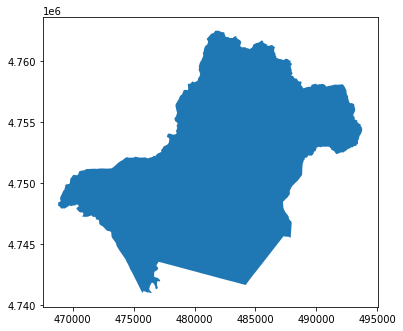

In [9]:
#画像に合わせて投影変換
out_file = os.path.join(shape_path + "re_N03-20_08_200101.shp")
re_shape = shape_srt.to_crs({"init": "epsg:32654"})

#出力
re_shape.to_file(driver="ESRI Shapefile",filename=out_file)
print("done")

#GeoDataFrameを描画
f,ax = plt.subplots(1, figsize=(6,6))
ax = re_shape.plot(axes=ax)
plt.show

In [10]:
for file_title in ziplis:
  print("Start make RGB TIF image " +'<'+ file_title +'>')

  path_A = str(file_title) + '.SAFE/GRANULE/'
  f1 = os.listdir(path_A)
  path_B = str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)
  path_C = str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b2 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B02.jp2'))
  b3 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B03.jp2'))
  b4 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B04.jp2'))
  
  
  RGB_path = os.path.join(RGB_dir,'sentinel-2_'+str(f3[0][7:15])+'_RGB.tif')
  

  RGB_colar = rio.open(RGB_path,'w',driver='Gtiff',
                       width=b4.width, height=b4.height,
                       count=3,
                       crs=b4.crs,
                       transform=b4.transform,
                       dtype=rasterio.uint16
                       )
  RGB_colar.write(b2.read(1),3) 
  RGB_colar.write(b3.read(1),2) 
  RGB_colar.write(b4.read(1),1) 
  RGB_colar.close()

  print("---masking---")

  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  with rasterio.open(RGB_path) as src:
    out_image, out_transform = rasterio.mask.mask(src, masks, crop=True)
    out_meta = src.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(RGB_path, "w", **out_meta) as dest:
    dest.write(out_image)
  
  #画像表示のため8bit形式で書き出し。
  scale = '-scale 0 255 0 15'
  options_list = ['-ot Byte','-of Gtiff',scale]
  options_string = " ".join(options_list)

  gdal.Translate(os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f1[0][19:27])+'.tif'),os.path.join(RGB_dir + "/" + 'sentinel-2_'+str(f1[0][19:27])+'_RGB.tif'),options = options_string)

  print("Done")

Start make RGB TIF image <S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317>
---masking---
Done
Start make RGB TIF image <S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006>
---masking---
Done
Start make RGB TIF image <S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116>
---masking---
Done


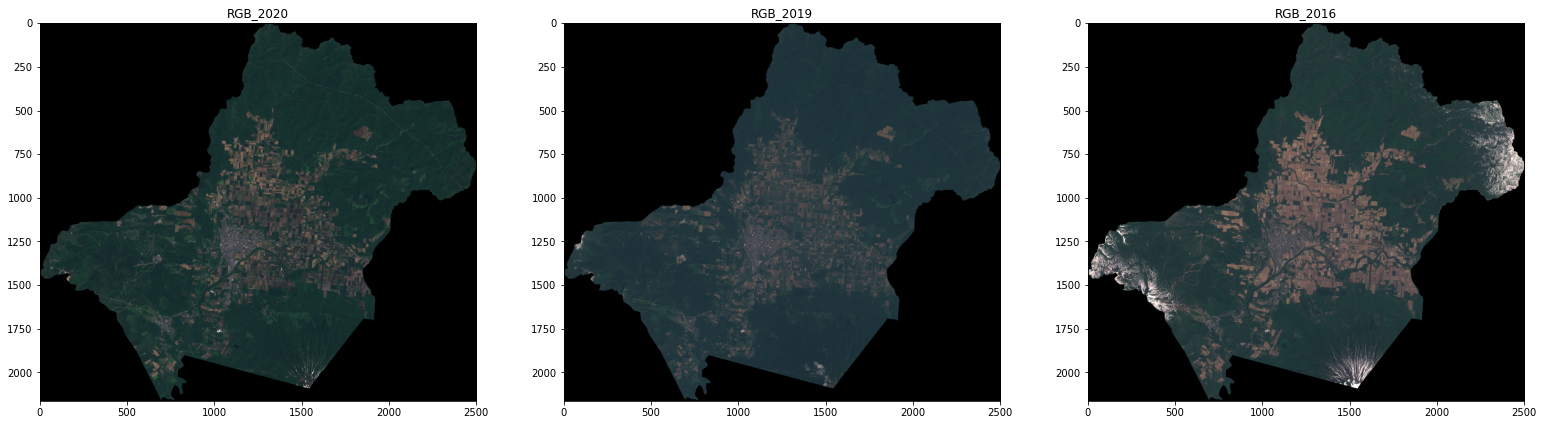

In [11]:
plt.figure(figsize=(36,36))

RGB_2020 = rio.open(RGB_dir+'/sentinel-2_20200621.tif')
RGB_2019 = rio.open(RGB_dir+'/sentinel-2_20190710.tif')
RGB_2016 = rio.open(RGB_dir+'/sentinel-2_20160523.tif')

ax1 = plt.subplot(1,4,1)
ax1.set_title("RGB_2020")
ax2 = plt.subplot(1,4,2)
ax2.set_title("RGB_2019")
ax3 = plt.subplot(1,4,3)
ax3.set_title("RGB_2016")

show(RGB_2020.read([1,2,3]),ax=ax1)
show(RGB_2019.read([1,2,3]),ax=ax2)
show(RGB_2016.read([1,2,3]),ax=ax3)

正規化都市化指数（NDVI）の計算

In [12]:
NDVI_dir = '/content/work/NDVI'

for file_title in ziplis:
  print("Start make NDVI " +'<'+ file_title +'>')

  path_A = str(file_title) + '.SAFE/GRANULE/'
  f1 = os.listdir(path_A)

  path_B = str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)

  path_C = str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b11 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B11.jp2'))
  b8 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B8A.jp2'))

  red = b11.read()
  nir = b8.read()
  
  ndvi = np.where(((red != 0) & (nir != 0)),(red.astype(float)-nir.astype(float))/(red.astype(float)+nir.astype(float)), 0)

  out_meta = b11.meta
  out_meta.update(driver='GTiff')
  out_meta.update(dtype=rasterio.float32)

  NDVI_path = os.path.join(NDVI_dir,'sentinel-2_'+str(f3[0][7:15])+ '_ndvi.tif')

  with rio.open(NDVI_path, 'w', **out_meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

  print("---masking---")

  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  with rio.open(NDVI_path) as src2:
    out_image_ndvi, out_transform = rasterio.mask.mask(src2, masks, crop=True)
    out_meta = src2.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(NDVI_path, "w", **out_meta) as dst2:
    dst2.write(out_image_ndvi)

  print("Done")

Start make NDVI <S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


---masking---
Done
Start make NDVI <S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006>
---masking---
Done
Start make NDVI <S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116>
---masking---
Done


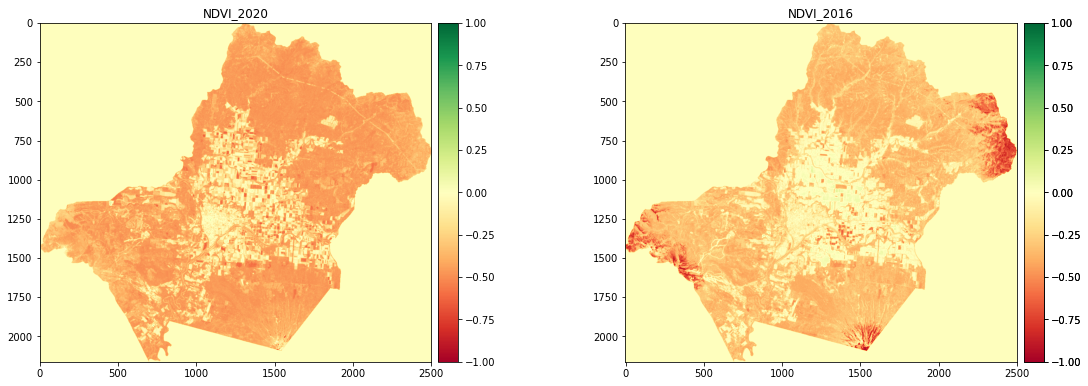

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(18,9))
plt.subplots_adjust(wspace=0.4)

NDVI_2020 = rio.open(NDVI_dir+'/sentinel-2_20200621_ndvi.tif')
NDVI_2019 = rio.open(NDVI_dir+'/sentinel-2_20190710_ndvi.tif')
NDVI_2016 = rio.open(NDVI_dir+'/sentinel-2_20160523_ndvi.tif')

NDVI_2020 = NDVI_2020.read(1)
NDVI_2019 = NDVI_2019.read(1)
NDVI_2016 = NDVI_2016.read(1)

ndvi1=ax1.imshow(NDVI_2020, cmap='RdYlGn')
ax1.set_title("NDVI_2020")
ndvi1.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi1, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2019, cmap='RdYlGn')
ax2.set_title("NDVI_2019")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2016, cmap='RdYlGn')
ax2.set_title("NDVI_2016")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)

正規化植生指数（NDVI）の計算

In [14]:
NDVI_dir = '/content/work/NDVI'

for file_title in ziplis:
  print("Start make NDVI " +'<'+ file_title +'>')

  path_A = str(file_title) + '.SAFE/GRANULE/'
  f1 = os.listdir(path_A)

  path_B = str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)

  path_C = str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b4 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B04.jp2'))
  b8 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B08.jp2'))
  
  red = b4.read()
  nir = b8.read()
  
  ndvi = np.where(((red != 0) & (nir != 0)),(nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float)), 0)

  out_meta = b4.meta
  out_meta.update(driver='GTiff')
  out_meta.update(dtype=rasterio.float32)

  NDVI_path = os.path.join(NDVI_dir,'sentinel-2_'+str(f3[0][7:15])+ '_ndvi.tif')

  with rio.open(NDVI_path, 'w', **out_meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

  print("---masking---")

  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  with rio.open(NDVI_path) as src2:
    out_image_ndvi, out_transform = rasterio.mask.mask(src2, masks, crop=True)
    out_meta = src2.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(NDVI_path, "w", **out_meta) as dst2:
    dst2.write(out_image_ndvi)

  print("Done")

Start make NDVI <S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


---masking---
Done
Start make NDVI <S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006>
---masking---
Done
Start make NDVI <S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116>
---masking---
Done


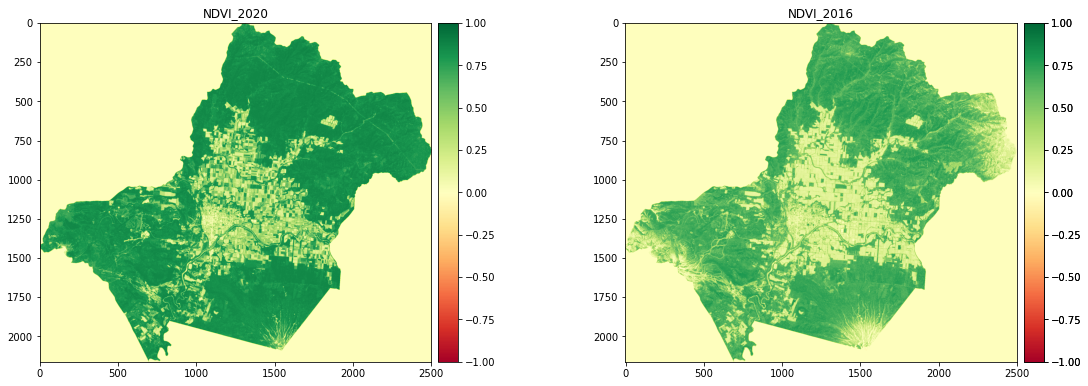

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(18,9))
plt.subplots_adjust(wspace=0.4)

NDVI_2020 = rio.open(NDVI_dir+'/sentinel-2_20200621_ndvi.tif')
NDVI_2019 = rio.open(NDVI_dir+'/sentinel-2_20190710_ndvi.tif')
NDVI_2016 = rio.open(NDVI_dir+'/sentinel-2_20160523_ndvi.tif')

NDVI_2020 = NDVI_2020.read(1)
NDVI_2019 = NDVI_2019.read(1)
NDVI_2016 = NDVI_2016.read(1)


ndvi1=ax1.imshow(NDVI_2020, cmap='RdYlGn')
ax1.set_title("NDVI_2020")
ndvi1.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi1, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2019, cmap='RdYlGn')
ax2.set_title("NDVI_2019")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2016, cmap='RdYlGn')
ax2.set_title("NDVI_2016")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)

BUの計算

In [ ]:
ndbi-ndvi

array([[[-0.03108007, -0.01686812, -0.00374363, ..., -0.12273833,
         -0.21709684, -0.32419432],
        [-0.04171705, -0.02318078, -0.00774206, ..., -0.2268599 ,
         -0.27838276, -0.20376687],
        [-0.0431416 , -0.05960179, -0.00933519, ..., -0.19830393,
         -0.37906086, -0.07373084],
        ...,
        [-0.31233311, -0.28902479, -0.28495479, ...,  0.        ,
          0.        ,  0.        ],
        [-0.4492913 , -0.33163672, -0.2647332 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.51355756, -0.31875591, -0.28869539, ...,  0.        ,
          0.        ,  0.        ]]])

In [16]:
NDVI_dir = '/content/work/NDVI'

for file_title in ziplis:
  print("Start make NDVI " +'<'+ file_title +'>')

  path_A = str(file_title) + '.SAFE/GRANULE/'
  f1 = os.listdir(path_A)

  path_B = str(file_title) + '.SAFE/GRANULE/' + str(f1[0])
  f2 = os.listdir(path_B)

  path_C = str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) + '/IMG_DATA/'
  f3 = os.listdir(path_C)

  b11 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B11.jp2'))
  b8 = rio.open(str(file_title) + '.SAFE/GRANULE/' + str(f1[0]) +'/IMG_DATA/' +str(f3[0][0:23] +'B8A.jp2'))

  red = b11.read()
  nir = b8.read()
  
  ndvi = np.where(((red != 0) & (nir != 0)),((red.astype(float)-nir.astype(float))/(red.astype(float)+nir.astype(float))-(nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))), 0)

  out_meta = b11.meta
  out_meta.update(driver='GTiff')
  out_meta.update(dtype=rasterio.float32)

  NDVI_path = os.path.join(NDVI_dir,'sentinel-2_'+str(f3[0][7:15])+ '_ndvi.tif')

  with rio.open(NDVI_path, 'w', **out_meta) as dst:
    dst.write(ndvi.astype(rasterio.float32))

  print("---masking---")

  with fiona.open(out_file, "r") as mask:
    masks = [feature["geometry"] for feature in mask]

  with rio.open(NDVI_path) as src2:
    out_image_ndvi, out_transform = rasterio.mask.mask(src2, masks, crop=True)
    out_meta = src2.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(NDVI_path, "w", **out_meta) as dst2:
    dst2.write(out_image_ndvi)

  print("Done")

Start make NDVI <S2A_MSIL1C_20200621T012701_N0209_R074_T54TVN_20200621T031317>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


---masking---
Done
Start make NDVI <S2A_MSIL1C_20190710T013701_N0208_R117_T54TVN_20190710T033006>
---masking---
Done
Start make NDVI <S2A_MSIL1C_20160523T012702_N0202_R074_T54TVN_20160523T013116>
---masking---
Done


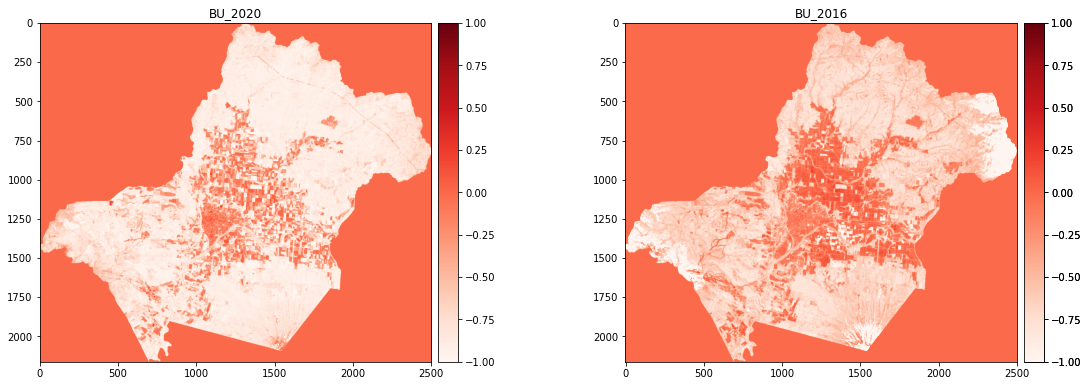

In [18]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(18,9))
plt.subplots_adjust(wspace=0.4)

NDVI_2020 = rio.open(NDVI_dir+'/sentinel-2_20200621_ndvi.tif')
NDVI_2019 = rio.open(NDVI_dir+'/sentinel-2_20190710_ndvi.tif')
NDVI_2016 = rio.open(NDVI_dir+'/sentinel-2_20160523_ndvi.tif')

NDVI_2020 = NDVI_2020.read(1)
NDVI_2019 = NDVI_2019.read(1)
NDVI_2016 = NDVI_2016.read(1)

ndvi1=ax1.imshow(NDVI_2020, cmap='Reds')
ax1.set_title("BU_2020")
ndvi1.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi1, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2019, cmap='Reds')
ax2.set_title("BU_2019")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)

ndvi2=ax2.imshow(NDVI_2016, cmap='Reds')
ax2.set_title("BU_2016")
ndvi2.set_clim(vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
ax_cb = divider.new_horizontal(size="5%", pad=0.1)
fig.add_axes(ax_cb)
plt.colorbar(ndvi2, cax=ax_cb)